# Proyecto Semestral - Entrega final

Luciano Davico  
Gregory Schuit  

En el presente notebook se presenta el análisis de datos sobre terremotos y tsunamis, especificamente mediante la implementación de un Random Forest para poder discriminar entre terremotos que ocasionan tsunamis y los que no.

In [3]:
import pandas as pd
import numpy as np
from time import time

# Data Preprocessing

In [4]:
# Leemos los datos de terremotos y filtramos las features.
quakes_df = pd.read_csv('Data/quakes.csv')
print(len(quakes_df))
quakes_df.columns

415677


Index(['time', 'latitude', 'longitude', 'depth', 'mag', 'magType', 'nst',
       'gap', 'dmin', 'rms', 'net', 'id', 'updated', 'place', 'type',
       'horizontalError', 'depthError', 'magError', 'magNst', 'status',
       'locationSource', 'magSource'],
      dtype='object')

In [5]:
quakes_df = quakes_df[['latitude', 'longitude', 'depth', 'mag', 'time']]
quakes_df.head()

,latitude,longitude,depth,mag,time
0,37.6457,20.8702,10.00,4.7,2018-10-27T18:33:12.420Z
1,65.2234,-151.6636,16.60,5.3,2018-10-27T16:57:27.956Z
2,-22.4704,-68.6516,113.79,4.7,2018-10-27T15:46:43.390Z
3,-56.0652,-27.4276,93.78,4.9,2018-10-27T15:00:46.800Z
4,37.3128,20.4930,10.00,4.6,2018-10-27T14:33:26.470Z


In [6]:
min(quakes_df['time'])

'1900-07-29T06:59:00.000Z'

In [7]:
# Leemos los dato de tsunamis y seleccionamos las features
tsunamis_df = pd.read_csv('Data/tsunamis.tsv', sep='\t', encoding='iso-8859-1')
tsunamis_df = tsunamis_df[tsunamis_df['YEAR'] >= 1900]
tsunamis_df = tsunamis_df[['PRIMARY_MAGNITUDE', 'LATITUDE', 'LONGITUDE', 'YEAR']]
print(len(tsunamis_df))
tsunamis_df.head()

773


,PRIMARY_MAGNITUDE,LATITUDE,LONGITUDE,YEAR
372,6.6,-4.0,152.0,1900
373,7.1,-5.0,148.0,1900
374,6.9,-4.0,140.0,1900
375,8.4,11.0,-66.0,1900
376,6.0,39.0,143.0,1901


Es posibe observar que existen 415677 terremotos y tan solo 1145 tsunamis. Este problema de desbalance se nivelará filtrando intervalos con muchos terremotos y pocos tsunamis, es decir, el rango de magnitudes bajas. A continuación observaremos los datos para determinar un punto de corte.

In [8]:
# Observamos distribuciones de la magnitud
plt = tsunamis_df['PRIMARY_MAGNITUDE'].hist(bins=40, figsize=(10, 3))

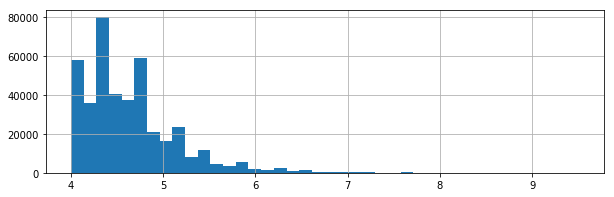

In [9]:
plt = quakes_df['mag'].hist(bins=40, figsize=(10, 3))

A partir de los histogramas, es posible apreciar que la gran mayoria de los terremotos bajo 6 grados aproximadamente, no genera tsunami alguno. Por esta razón es que lo consideraremos como el punto de corte.

In [10]:
corte = 6.3
print(len(tsunamis_df[tsunamis_df['PRIMARY_MAGNITUDE'] > corte]))
print(len(quakes_df[quakes_df['mag'] > corte]))

663
4930


In [11]:
tsunamis_df = tsunamis_df[tsunamis_df['PRIMARY_MAGNITUDE'] > corte]
quakes_df = quakes_df[quakes_df['mag'] > corte]

Ahora, procederemos a hacer el join de ambas tablas

In [12]:
# Creamos una nueva columna en el dataset de terremotos,
# que por defecto será la ausencia de tsunami.
quakes_df['tsunami'] = 0

t0, i, total = time(), 0, len(quakes_df)
for index, row in quakes_df.iterrows():  # Para cada terremoto, se busca la correspondencia
    lat = row['latitude']                # en la tabla tsunamis.
    lon = row['longitude']
    mag = row['mag']
    year = int(row['time'][:4])
    
    delta_pos = 2.5  # valores tuneados a mano para el margen de error.
    delta_mag = 0.3
    
    cond1 = abs(tsunamis_df['LATITUDE'] - lat) < delta_pos
    cond2 = abs(tsunamis_df['LONGITUDE'] - lon) < delta_pos
    cond3 = abs(tsunamis_df['PRIMARY_MAGNITUDE'] - mag) < delta_mag
    cond4 = tsunamis_df['YEAR'] == year
    
    # Si existe un elemento en la tabla de tsunamis con las features muy cercanas,
    # se le asocia al terremoto.
    if len(tsunamis_df.loc[cond1 & cond2 & cond3 & cond4]) >= 1:
        quakes_df.at[index, 'tsunami'] = 1
    else:
        quakes_df.at[index, 'tsunami'] = 0
    
    i += 1
    if i % 80 == 0:
        print('Seconds left: {:.2f}'.format((time() - t0)/i * (total - i)), end='\r')

print('Total time: {:.2f}'.format(time() - t0))
len(quakes_df[quakes_df['tsunami'] == 1]), len(tsunamis_df)

Total time: 22.8232


(671, 663)

In [13]:
quakes_df.head()

,latitude,longitude,depth,mag,time,tsunami
79,37.5055,20.5626,14.00,6.8,2018-10-25T22:54:51.830Z,1
147,49.3142,-129.6725,10.00,6.5,2018-10-22T06:22:48.810Z,0
148,49.3468,-129.2135,10.00,6.8,2018-10-22T06:16:28.160Z,0
149,49.2496,-129.4783,10.96,6.6,2018-10-22T05:39:40.330Z,0
335,-21.7260,169.4867,10.00,6.4,2018-10-16T01:03:43.090Z,0


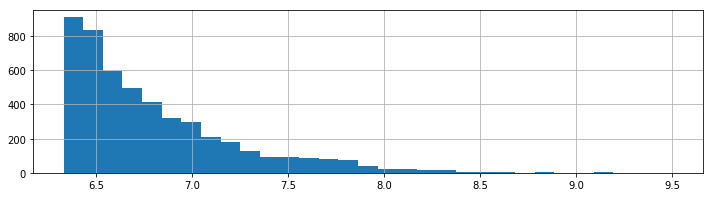

In [14]:
# Magnitudes de todos los terremotos
plt = quakes_df['mag'].hist(bins=31, figsize=(12,3))

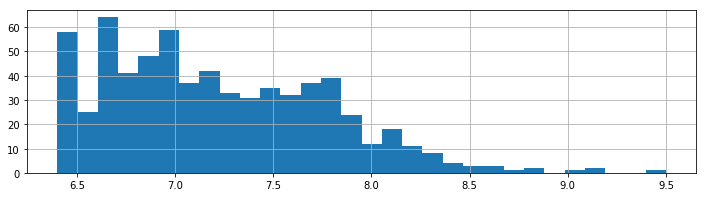

In [15]:
# Magnitudes de terremotos que provocaron tsunamis
plt = quakes_df[quakes_df['tsunami'] == 1]['mag'].hist(bins=30, figsize=(12,3))

### Train and test

Debido al desbalance de los datos, la partición de sets de training y testing se hará estratificada.

In [16]:
np.random.seed(123)

shuffled = quakes_df.loc[np.random.permutation(quakes_df.index)]

clase0 = shuffled[shuffled['tsunami'] == 0]
clase1 = shuffled[shuffled['tsunami'] == 1]

p80_clase0 = int(len(clase0) * 0.8)  # percentiles 80
p80_clase1 = int(len(clase1) * 0.8)

train0 = clase0[:p80_clase0]
train1 = clase1[:p80_clase1]

test0 = clase0[p80_clase0:]
test1 = clase1[p80_clase1:]

train = pd.concat([train0, train1])
test = pd.concat([test0, test1])
len(train), len(test)

(3943, 987)

# Random Forest

<center>$Entropy(S) = p \cdot Log(p)$</center>

In [208]:
class Node:
    """
    EDD principal para generar un árbol de regresión.
    """
    
    def __init__(self, feature=None, division_point=None, leaf=False, data=None):
        self.left_child = None  # de la clase Node
        self.right_child = None  # de la clase Node
        self.feature = feature  # Atributo que instancian sus hijos
        self.division_point = division_point  # punto de division que separa a sus hijos
        self.leaf = leaf  # Indica si es un nodo hoja
        self.data = data  # Si es que es un nodo hoja, contiene las particiones de los datos
        
    @property
    def depth(self):
        d = 0
        if self.left_child:
            d = 1 + self.left_child.depth
        if self.right_child:
            d = max(d, 1 + self.right_child.depth)
        return d
    
    @property
    def number_of_leaves(self):
        if self.leaf:
            return 1
        return self.left_child.number_of_leaves + self.right_child.number_of_leaves
    
    @property
    def total_var(self):
        if self.leaf:
            return self.data['tsunami'].var(ddof=0)
        return self.left_child.total_var + self.right_child.total_var
        
    def __repr__(self):
        if not self.leaf:
            ret = "feature: {}\ndivision_point: {}\ndepth: {}\nleaves: {}".format(self.feature,
                                                                                  self.division_point,
                                                                                  self.depth,
                                                                                  self.number_of_leaves)
        else:
            ret = "Hoja\nNúmero de datos: {}\nMean: {}\nstd: {}".format(len(self.data),
                                                                        self.data.mean(),
                                                                        self.data.std(ddof=0))
        return ret

In [ ]:
def entropy(data_left, data_right):
    p_left = len(data_left[data_left['tsunami'] == 0]) / len(data_left)
    p_right = len(data_right[data_right['tsunami'] == 1]) / len(data_left)
    

In [99]:
def best_division_point(data, feature, target):
    """
    Calcula las varianzas de manera incremental para cada dato como punto divisorio
    de los datos y entrega el index del que minimiza la varianza.
    """
    
    print("Computing best division point for feature {}...                 ".format(feature), end='\r')
    t0 = time()
    
    if len(data[feature].unique()) == 1:  # si todos los valores de feature son iguales
        return 0, float('inf'), 0
    
    # Ordenamos los datos según la feature
    ordered = data.sort_values(feature)
    total = len(ordered)

    # Entropia base
    p0 = len(data[data[target] == 0]) / len(data)
    p1 = len(data[data[target] == 1]) / len(data)
    e = p0*np.log2(p0) + p1*np.log2(p1)
    
#     print('holi')
    
    # Maximizar el gain es lo mismo que minimizar la entropia de las particiones.
    data_left = ordered[:1]
    data_right = ordered[1:]
    
#     print('holi')
    
    p0_left = len(data_left[data_left[target] == 0])
    p0_right = len(data_right[data_right[target] == 0])
#     print('holi')
    
    p1_left = len(data_left[data_left[target] == 1])
    p1_right = len(data_right[data_right[target] == 1])
    
    e_left = p0_left*np.log2(p0_left) + p1_left*np.log2(p1_left) if p0_left != 0 and p1_left != 0 else 0
    e_right = p0_right*np.log2(p0_right) + p1_right*np.log2(p1_right) if p0_right != 0 and p1_right != 0 else 0
    
    leaves_entropy = e_left + e_right  # cantidad a minimizar
    minimum, best_division = float('inf'), 0
        
#     print('holi')

    dato_anterior = data[feature][0]
    for i, row in enumerate(data[target][1:]):               
        if data.iloc[i + 1][target] == 0:
            p0_left += 1
            p0_right -= 1
        else:
            p1_left += 1
            p1_right -= 1
    
        e_left = p0_left * np.log2(p0_left) + p1_left * np.log2(p1_left) if p0_left != 0 and p1_left != 0 else 0
        e_right = p0_right * np.log2(p0_right) + p1_right * np.log2(p1_right) if p0_right != 0 and p1_right != 0 else 0
    
        new_entropy = e_left + e_right
        if new_entropy < minimum:  # cantidad a minimizar
            if data[feature][i + 1] == dato_anterior:  # esto es para que el corte no 
                continue                               # divida datos iguales
            minimum, best_division = new_entropy, i + 1
        
        dato_anterior = data[feature][i + 1]


    # retornamos el index del mejor punto de división junto con la varianza obtenidax
    idxs_left = [ordered.index[idx] for idx in range(best_point + 1)]
    idxs_right = [ordered.index[idx] for idx in range(best_point + 1, len(ordered))]
    
    # print("Best division point founded for {} in {:.4f} seconds.".format(feature, time() - t0))
    return ordered.index[best_point], minimum, [idxs_left, idxs_right]

In [100]:
def prepoda(datos):
    if len(datos) < len(datos)*0.05:
        return True
    return False

def fit(data, target, max_depth=None):
    """
    Función recursiva para generar el árbol de regresión óptimo.
    """
    
    # Condición de término:
    if max_depth == 0 or prepoda(data):
        hoja = Node(leaf=True)
        hoja.data = data
        return hoja
    
    t0 = time()
    print("Computing best feature... Depth: {}".format(max_depth))
    
    features = [col for col in data.columns if col != target]

    best_feature = features[0]
    best_point, best_minimum, best_idxs = best_division_point(data, best_feature, target)
    for feature in features[1:]:
        point, minimum, idxs = best_division_point(data, feature, target)
        if minimum < best_minimum:
            best_feature = feature
            best_point = point
            best_minimum = minimum
            best_idxs = idxs  # filas de la particion
    
    print("Best feature found in {:.4f} seconds: {}, division_point: {}.".format(time() - t0, best_feature, best_point))
    
    print("Creating childs...")
    root = Node(feature=best_feature, division_point=data[best_feature][best_point])
    
    left_data = data.loc[best_idxs[0]]
    right_data = data.loc[best_idxs[1]]
    
    root.left_child = fit(left_data, target, max_depth - 1 if max_depth else None)
    print("Left child ready. Current time: {:.4f} seconds".format(time() - t0))
    root.right_child = fit(right_data, target, max_depth - 1 if max_depth else None)
    print("Right child ready. Current time: {:.4f} seconds".format(time() - t0))
    
    return root   

In [101]:
def predict(row, tree, target='PeriodLS'):
    """
    Recorre un árbol de regresión para predecir la clase del dato entregado.
    """
    
    # Buscamos la hoja
    while not tree.leaf:
        if row[tree.feature] < tree.division_point:
            tree = tree.left_child
        else:
            tree = tree.right_child
    
    # Predecimos en base a lo que haya en la hoja
    return tree.data[target].mean()

In [102]:
regression_tree = fit(train, 'tsunami', 5)

Computing best feature... Depth: 5


KeyError: 0

In [32]:
quakes_df['tsunami'][:1]

79    2
Name: tsunami, dtype: int64

In [78]:
quakes_df[:3]

,latitude,longitude,depth,mag,time,tsunami
79,37.5055,20.5626,14.0,6.8,2018-10-25T22:54:51.830Z,1
147,49.3142,-129.6725,10.0,6.5,2018-10-22T06:22:48.810Z,0
148,49.3468,-129.2135,10.0,6.8,2018-10-22T06:16:28.160Z,0


In [46]:
len(quakes_df['latitude'].unique())

4811

Int64Index([    79,    147,    148,    149,    335,    402,    467,    473,
               801,    910,
            ...
            414847, 414857, 415097, 415213, 415217, 415278, 415584, 415654,
            415655, 415670],
           dtype='int64', length=4930)